# Preparation

In [1]:
import glob
import json
import os
import random

from scipy.cluster._optimal_leaf_ordering import squareform
from sklearn.cluster import KMeans
import graphviz
import matplotlib.pyplot as plt
import nilearn.image as nimg
import numpy as np
import pandas as pd
import seaborn as sb
from matplotlib.colors import LinearSegmentedColormap
from nilearn import plotting
from scipy.cluster.hierarchy import fcluster, linkage
from sklearn import tree
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from aafm.AAFM_service import AAFMService
from aafm.sample_service import SampleService
from core.file_service import FileService
from core.postprocess_service import PostprocessService
from matplotlib.ticker import FixedLocator

In [2]:
# load global vars
postproc_srv = PostprocessService()
sample_srv = SampleService()
aafm_srv = AAFMService()
file_srv = FileService()
basedir = "/home/ymerel/storage/results/auditory"
mean_path = os.path.join(basedir, 'mean_result.nii')
df_path = os.path.join(basedir, 'dataset.csv')
corr_path = os.path.join(basedir, 'correlations.csv')
ids = []
results = []
paths = glob.glob(os.path.join(basedir, '*/'), recursive=True)
for path in paths:
    ids.append(os.path.basename(os.path.dirname(path)))
    results.append(os.path.join(path, '_subject_id_01', 'result.nii'))

# Show pipeline diagram

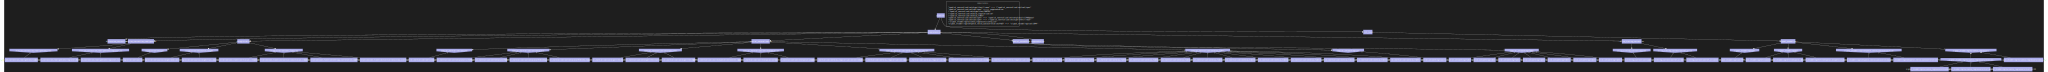

In [3]:
# Load the .dot file
with open('/home/ymerel/fmri-feature-model/model/uvl/full_pipeline.dot', 'r') as file:
    dot_data = file.read()

# Create a Graphviz Source object
src = graphviz.Source(dot_data)

# Render the graph to a file (e.g., PDF, PNG)
src.render('full_pipeline', format='png', cleanup=True)

# Display the graph (if using Jupyter Notebook)
src

# Load dataset
90 features + config hash (id) + correlation from ref + correlation from mean

In [4]:
# Mount group storage
!sshfs -o reconnect,ServerAliveInterval=120,ServerAliveCountMax=3 rennes.g5k:/srv/storage/empenn@storage2.rennes.grid5000.fr/private/ymerel /home/ymerel/storage
# load correlations
correlations = pd.read_csv(corr_path, delimiter=';')
matrix = correlations.pivot(index='source', columns='target', values='correlation').fillna(1.0)
distance_matrix = 1 - matrix

fusermount3: failed to access mountpoint /home/ymerel/storage: Permission denied


In [5]:
# write extended dataset (with mean of correlations, 10 random ref)
# Choose 10 random correlations as refs
def get_extended_dataset():
    unique_values = [value for value in correlations['source'].unique() if value not in ['ref', 'mean']]
    random_refs = random.sample(list(unique_values), 10)
    extended_dataset = pd.read_csv(df_path, delimiter=';')
    for ref in random_refs:
        print(f"Fetching correlations for random ref [{ref}]")
        for index, row in extended_dataset.iterrows():
            id_value = row['id']
            correlation = correlations.loc[
            (correlations['source'] == id_value) &
            (correlations['target'] == ref), 'correlation'].values[0]
            extended_dataset.at[index, f'from_{ref}'] = correlation
    print(f"Calculating mean of correlations for each config")
    for index, row in extended_dataset.iterrows():
            id_value = row['id']
            if id_value == 'ref' or id_value == 'mean':
                continue
            values = correlations.loc[
            (correlations['source'] == id_value) & (correlations['target'] != id_value) & (correlations['target'] != 'ref') & (correlations['target'] != 'mean'), 'correlation'].values
            extended_dataset.at[index, f'mean_corr'] =  sum(values) / len(values)
    # write dataset
    extended_dataset.to_csv(os.path.join(basedir, 'extended_dataset.csv'), index=False, sep=';')

# get_extended_dataset()

cluster
2.0    556
1.0    195
4.0    177
3.0     72
Name: count, dtype: int64


<Figure size 2000x2000 with 0 Axes>

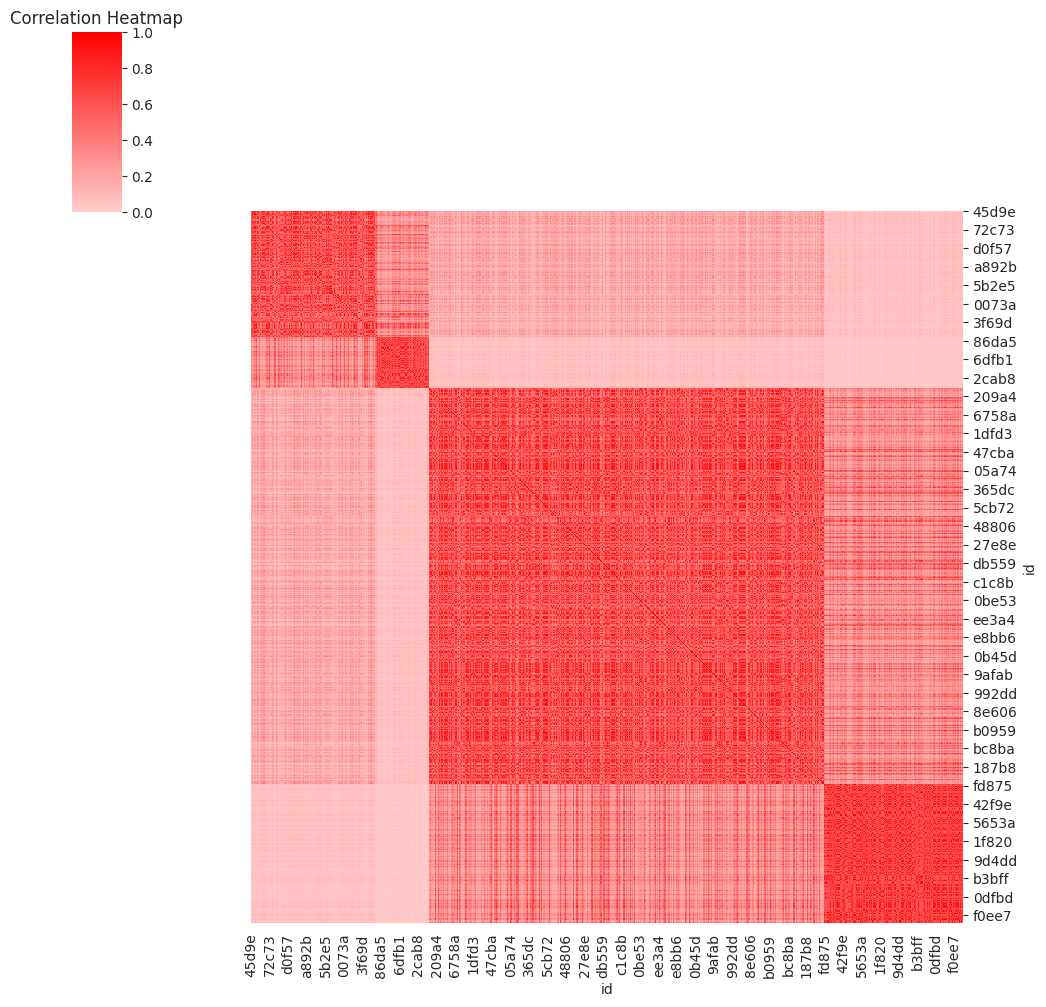

In [6]:
def clusterize(ids: list, nb_clusters: int, mean: False):
    filtered_ds = dataset[dataset['id'].isin(ids)]
    filtered_corr = correlations[correlations['source'].isin(ids) & correlations['target'].isin(ids)]
    filtered_matrix = filtered_corr.pivot(index='source', columns='target', values='correlation').fillna(1.0)
    filtered_distance_matrix = 1 - filtered_matrix 
    
    Z = linkage(squareform(filtered_distance_matrix), method='complete')
    clusters = fcluster(Z, nb_clusters, criterion='maxclust')

    mapping = pd.DataFrame({'config': filtered_distance_matrix.index, 'cluster': clusters})

    for id, row in mapping.iterrows():
        config = row['config']
        cluster = row['cluster']
        filtered_ds.loc[filtered_ds['id'] == config, 'cluster'] = int(cluster)
    
    if mean:
        # recalculate mean of correlations
        for index, row in filtered_ds.iterrows():
                id_value = row['id']
                if id_value == 'ref' or id_value == 'mean':
                    continue
                values = correlations.loc[
                (correlations['source'] == id_value) & (correlations['target'] != id_value) & (correlations['target'] != 'ref') & (correlations['target'] != 'mean'), 'correlation'].values
                filtered_ds.at[index, f'mean_corr'] =  sum(values) / len(values)
        
    filtered_ds = filtered_ds.sort_values(by='id', ascending=False)
    return filtered_ds, filtered_matrix, Z


dataset = pd.read_csv(os.path.join(basedir, 'extended_dataset.csv'), delimiter=';')
target_vars = [col for col in dataset.columns if col.startswith('from_')]
target_vars.append('mean_corr')

dataset, matrix, Z = clusterize(dataset["id"], 4, False)
cluster_counts = dataset['cluster'].value_counts()
print(cluster_counts)
plt.figure(figsize=(20, 20))
cmap = LinearSegmentedColormap.from_list("red_cmap", ["#FFCCCC", "#FF0000"])

# reorder matrix by cluster
sorted_index = dataset.sort_values('cluster', ascending=False)['id']
matrix = matrix.reindex(index=sorted_index, columns=sorted_index)
matrix.index = matrix.index.str.slice(0, 5)
matrix.columns = matrix.columns.str.slice(0, 5)
map = sb.clustermap(matrix, cmap=cmap, vmin=0, vmax=1, row_cluster=False, col_cluster=False, row_linkage=Z, col_linkage=Z)
plt.title('Correlation Heatmap')
plt.show()

# Features repartition
Check features repartition for all configurations vs sample

Retrieved all [27648] configurations from [/home/ymerel/fmri-feature-model/model/uvl/full_pipeline.uvl]


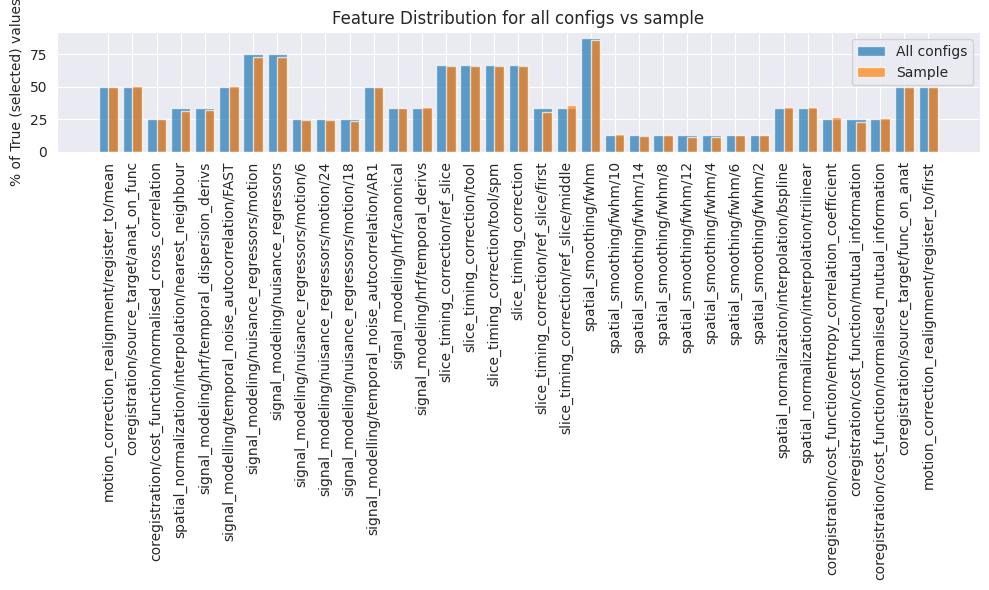

In [7]:
pd.set_option('future.no_silent_downcasting', True)
full = pd.DataFrame(sample_srv.get_all_configs()).fillna(False).astype(bool)
full_rep = full.mean() * 100
full_rep = full_rep[(full_rep > 0) & (full_rep < 100)]
ignored = target_vars.copy()
ignored.append('id')
ignored.append('cluster')
sample_rep = dataset.drop(columns=ignored).mean() * 100
sample_rep = sample_rep[(full_rep > 0) & (sample_rep < 100)]
# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the percentages for df1
ax.bar(full_rep.index, full_rep, alpha=0.7, label='All configs')

# Plot the percentages for df2
ax.bar(sample_rep.index, sample_rep, alpha=0.7, label='Sample', align='edge', width=0.4)

# Add labels and title
ax.set_ylabel('% of True (selected) values')
ax.set_title('Feature Distribution for all configs vs sample')
ax.legend()

# Show plot
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

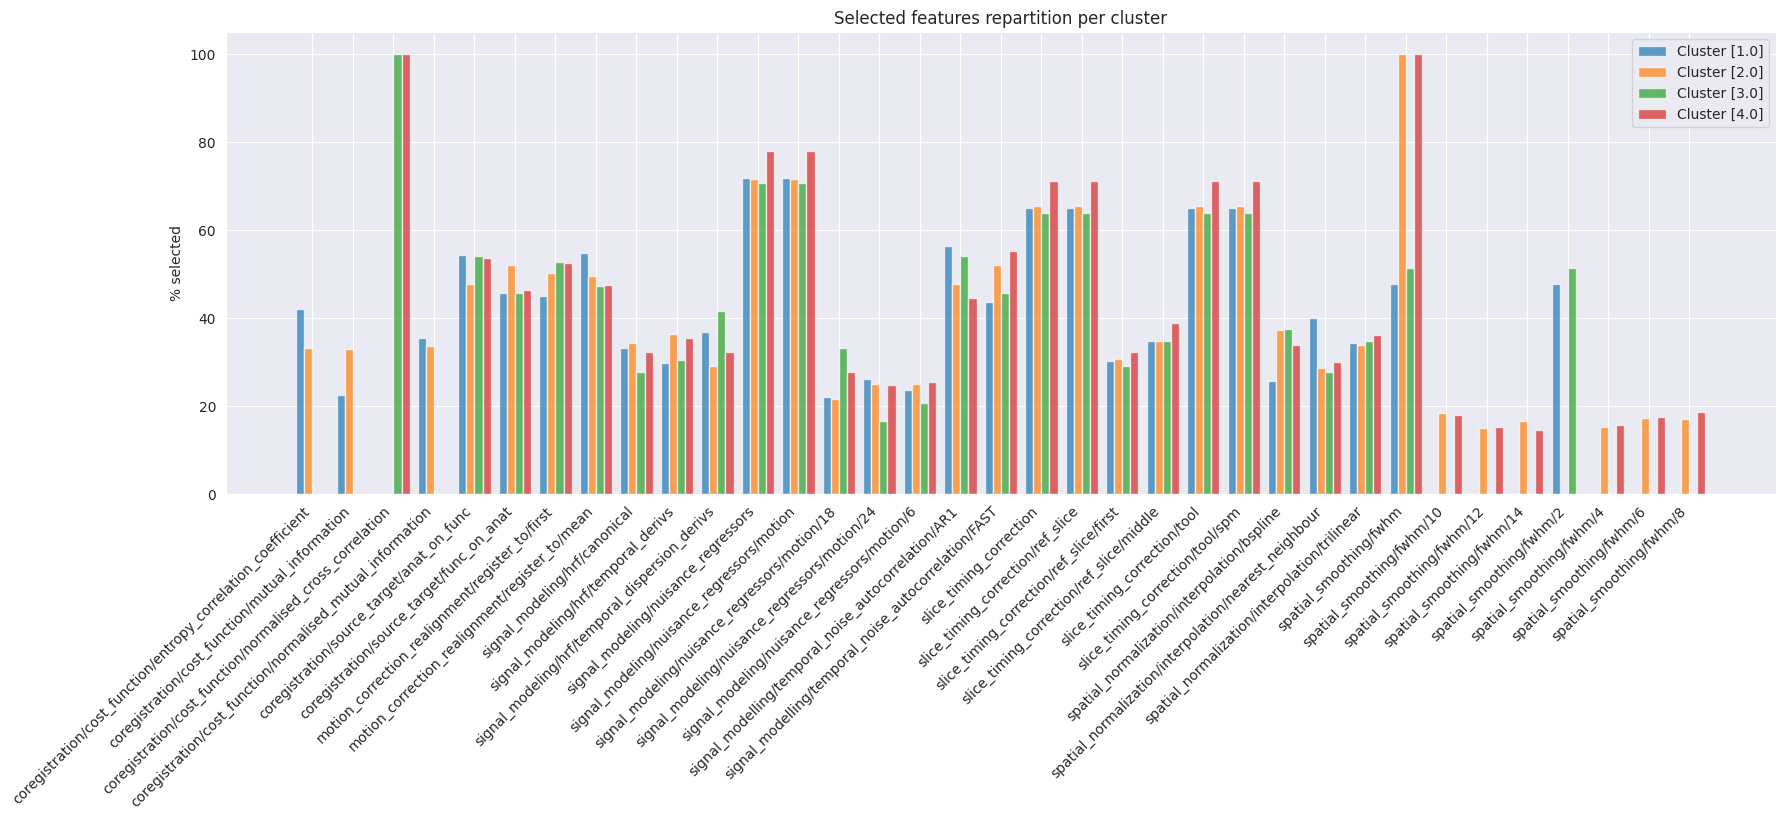

,coregistration/cost_function/entropy_correlation_coefficient,coregistration/cost_function/mutual_information,coregistration/cost_function/normalised_cross_correlation,coregistration/cost_function/normalised_mutual_information,coregistration/source_target/anat_on_func,coregistration/source_target/func_on_anat,motion_correction_realignment/register_to/first,motion_correction_realignment/register_to/mean,signal_modeling/hrf/canonical,signal_modeling/hrf/temporal_derivs,...,spatial_normalization/interpolation/nearest_neighbour,spatial_normalization/interpolation/trilinear,spatial_smoothing/fwhm,spatial_smoothing/fwhm/10,spatial_smoothing/fwhm/12,spatial_smoothing/fwhm/14,spatial_smoothing/fwhm/2,spatial_smoothing/fwhm/4,spatial_smoothing/fwhm/6,spatial_smoothing/fwhm/8
cluster,,,,,,,,,,,,,,,,,,,,,
1.0,42.051282,22.564103,0.0,35.384615,54.358974,45.641026,45.128205,54.871795,33.333333,29.743590,...,40.000000,34.358974,47.692308,0.000000,0.000000,0.000000,47.692308,0.000000,0.000000,0.000000
2.0,33.273381,33.093525,0.0,33.633094,47.841727,52.158273,50.359712,49.640288,34.352518,36.510791,...,28.776978,33.812950,100.000000,18.525180,15.107914,16.726619,0.000000,15.287770,17.266187,17.086331
3.0,0.000000,0.000000,100.0,0.000000,54.166667,45.833333,52.777778,47.222222,27.777778,30.555556,...,27.777778,34.722222,51.388889,0.000000,0.000000,0.000000,51.388889,0.000000,0.000000,0.000000
4.0,0.000000,0.000000,100.0,0.000000,53.672316,46.327684,52.542373,47.457627,32.203390,35.593220,...,29.943503,36.158192,100.000000,18.079096,15.254237,14.689266,0.000000,15.819209,17.514124,18.644068


In [8]:
columns_to_drop = ignored.copy()
columns_to_drop.remove('cluster')
boolean_columns = dataset.select_dtypes(include='bool')
for col in boolean_columns.columns:
    if dataset[col].all():
        columns_to_drop.append(col)
    if (dataset[col] == False).all():
        columns_to_drop.append(col)

filtered = dataset.drop(columns=columns_to_drop)
grouped = filtered.groupby('cluster').mean() * 100
grouped = grouped.sort_index(axis=1)


fig, ax = plt.subplots(figsize=(20, 6))
width = 0.4  # Width of each bar
group_spacing = 0.4  # Space between groups of bars
num_clusters = len(grouped)

# Define x positions for each cluster with additional spacing between groups
x = np.arange(len(grouped.columns)) * (num_clusters * width + group_spacing)

for i, cluster in enumerate(grouped.index):
    cluster_data = grouped.loc[cluster].to_frame().T
    # Offset the x positions for each cluster
    offsets = x + (i - num_clusters / 2) * width + width / 2
    ax.bar(offsets, cluster_data.values[0], alpha=0.7, label=f'Cluster [{cluster}]', width=width)

ax.set_xticks(x)
ax.set_xticklabels(cluster_data.columns, rotation=45, ha='right')
ax.set_ylabel('% selected')
ax.set_title('Selected features repartition per cluster')
ax.legend()

plt.show()

grouped.head(10)

# Convert feature with alternative to enum

In [9]:
str_alternatives = {
    "motion_correction_realignment/register_to" : ["first", "mean"],
    "coregistration/source_target" : ["anat_on_func", "func_on_anat"],
    "coregistration/cost_function" : ["mutual_information", "normalised_mutual_information", "entropy_correlation_coefficient", "normalised_cross_correlation"],
    "spatial_normalization/template" : ["Ixi549Space", "MNI305", "MNI152_linear", "MNI152_nonlinear"],
    "spatial_normalization/algorithm" : ["linear", "nonlinear", "DARTEL"],
    "spatial_normalization/interpolation" : ["nearest_neighbour", "trilinear", "bspline"],
    "spatial_normalization/bias_regularisation" : ["extremely_light", "very_light", "light", "medium", "heavy"],
    "slice_timing_correction/ref_slice" : ["first", "middle"],
    "signal_modeling/hrf" : ["canonical", "temporal_derivs", "temporal_dispersion_derivs"],
    "signal_modelling/temporal_noise_autocorrelation" : ["AR1", "FAST"],
}

num_alternatives = {
    "spatial_normalization/bias_fwhm" : [30, 40, 60, 70, 80, 90, 100, 110, 120,130,140,150],
    "spatial_smoothing/fwhm" : [2, 4, 6, 8, 10, 12, 14],
    "signal_modeling/nuisance_regressors/motion" : [6, 18, 24]
}

bias_regs = {
        'extremely_light': 0.00001,
        'very_light': 0.0001,
        'light': 0.001,
        'medium': 0.01,
        'heavy': 0.1
    }

for index, row in dataset.iterrows():
    for feature, values in num_alternatives.items():
        if row[feature] is False:
            dataset.at[index, feature] = 0
            continue
        for val in values:
            alt = f"{feature}/{val}"
            if row[alt] is True:
                dataset.at[index, feature] = val
    for label, value in bias_regs.items():
        if row[f"spatial_normalization/bias_regularisation/{label}"] is True:
            dataset.at[index, "spatial_normalization/bias_regularisation"] = value

for key in num_alternatives:
    for val in num_alternatives[key]:
        dataset = dataset.drop(f"{key}/{val}",  axis=1)
dataset = dataset.convert_dtypes()
# remove always true columns
boolean_columns = dataset.select_dtypes(include='bool').columns
columns_to_drop = [col for col in boolean_columns if dataset[col].all()]
dataset = dataset.drop(columns=columns_to_drop)
dataset.head()

/home/ymerel/tmp/ipykernel_57352/3860823572.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  dataset.at[index, feature] = 0
/home/ymerel/tmp/ipykernel_57352/3860823572.py:36: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  dataset.at[index, feature] = val
/home/ymerel/tmp/ipykernel_57352/3860823572.py:36: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '6' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  dataset.at[index, feature] = val


,slice_timing_correction/ref_slice/middle,signal_modeling/hrf/temporal_dispersion_derivs,coregistration/cost_function/mutual_information,signal_modeling/nuisance_regressors/comp_cor,signal_modelling/temporal_noise_autocorrelation/FAST,spatial_normalization/algorithm/DARTEL,spatial_normalization/interpolation/bspline,spatial_normalization/bias_regularisation,spatial_normalization/template/MNI152_linear,spatial_normalization/bias_regularisation/extremely_light,...,from_e2981f97fc870a8fc8a66d9a40c3cc8dcb21be746ad83ecbcc320c8fe4298a73,from_bdab21629030923da17e248d7689fc21eb1abea0d889d3b44c67b4baf6a07de5,from_6363ceb4ad5221e2fd865e8ba9181032905c33814f925c2e960adcd5354485e4,from_2566dc31e9fbea6d892a21f56ecb62ff9df850705b65b17754f772d13f060284,from_6b4189bcd2f407a23e0ebc2d14de55529eaab1b0f5a612ba46b79d019b03cc46,from_c475f858fc2881ef01d1d4b705346000d23d56508ee89dcbf18e173daf48de57,from_5b935ba44056218711fe041d9e5000904a788b010f7c12dd70041a2e5cc4e135,from_05a74cdcbd5faa976b866eec5a083de5e3945cc85a8971c44863127732e7026d,mean_corr,cluster
788,False,False,False,False,False,False,True,False,False,False,...,0.781534,0.599326,0.602902,0.912298,0.336283,0.307697,0.286491,0.585972,0.38504,1
183,False,False,False,False,False,False,True,False,False,False,...,0.041733,0.048517,0.018959,0.032519,0.045156,0.061031,0.043576,0.044345,0.136255,3
997,False,False,False,False,True,False,False,False,False,False,...,0.059874,0.07086,0.022124,0.042624,0.062141,0.08679,0.062172,0.05931,0.171592,3
602,True,True,False,False,True,False,False,False,False,False,...,0.351272,0.450279,0.13771,0.251884,0.663299,0.8771,0.479385,0.487748,0.404706,2
146,False,False,True,False,True,False,False,False,False,False,...,0.808281,0.92787,0.330229,0.607472,0.535102,0.538319,0.518996,0.59751,0.477375,2


# Ref correlations repartition

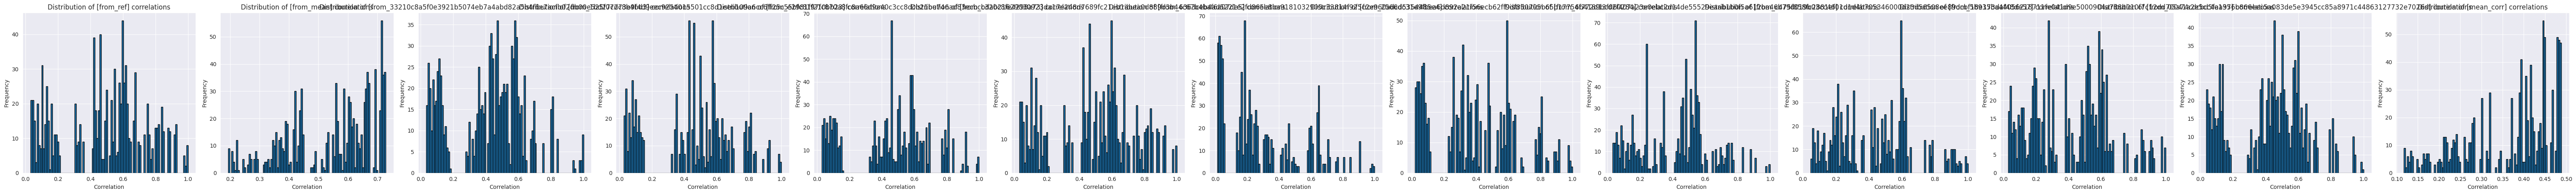

In [10]:
num_plots = len(target_vars)
fig, axes = plt.subplots(ncols=num_plots, figsize=(5 * num_plots, 5))

for i, corr in enumerate(target_vars):
    axes[i].hist(dataset[corr], bins=100, edgecolor='black')
    axes[i].set_title(f'Distribution of [{corr}] correlations')
    axes[i].set_xlabel('Correlation')
    axes[i].set_ylabel('Frequency')
plt.tight_layout()
plt.show()


# Stats maps QC

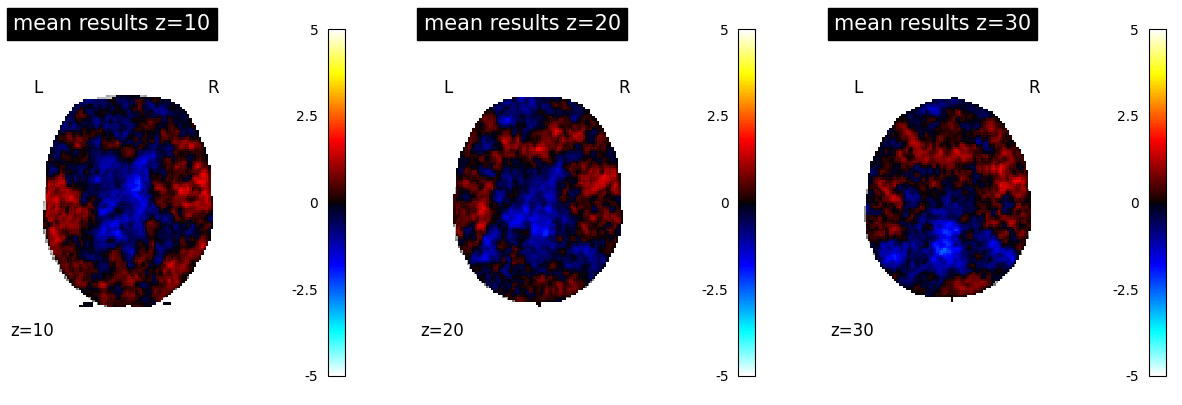

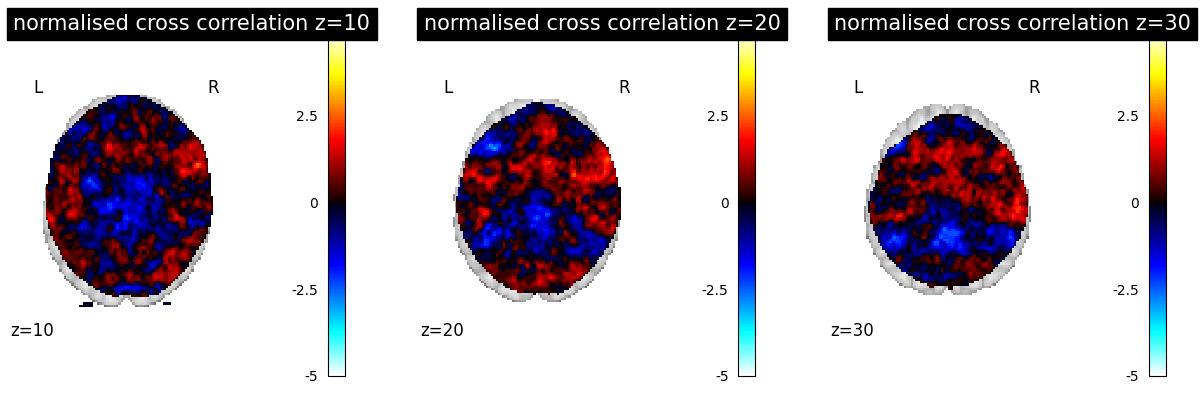

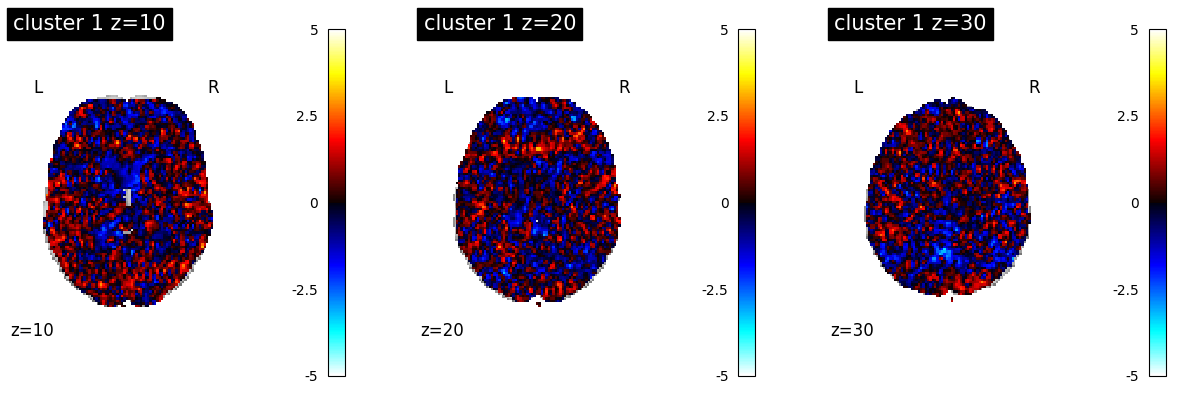

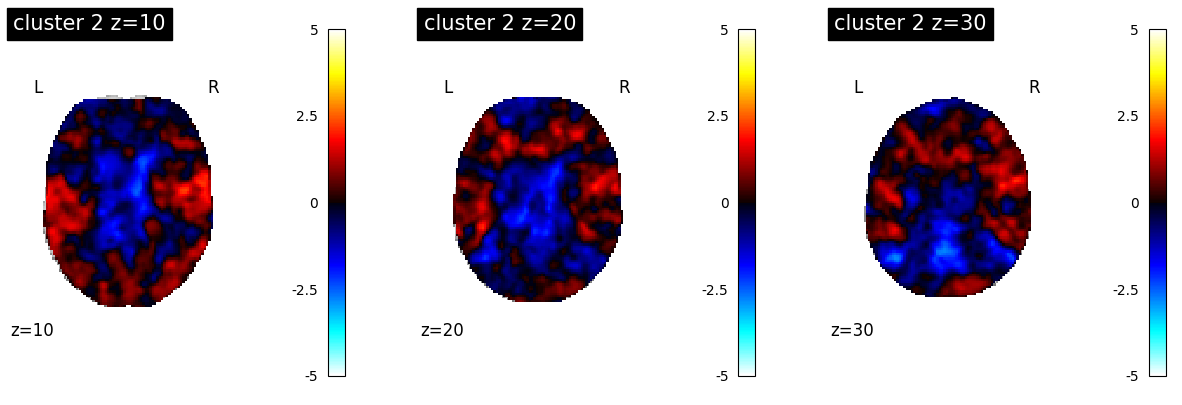

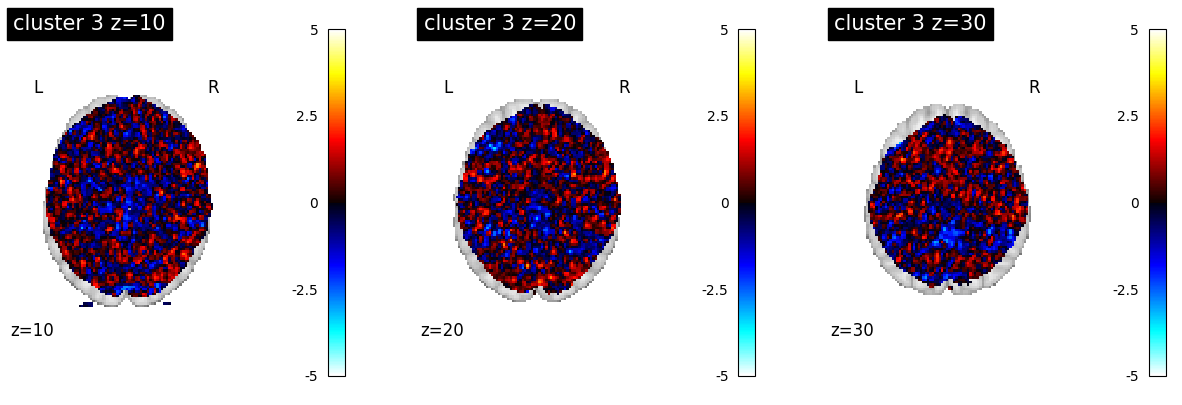

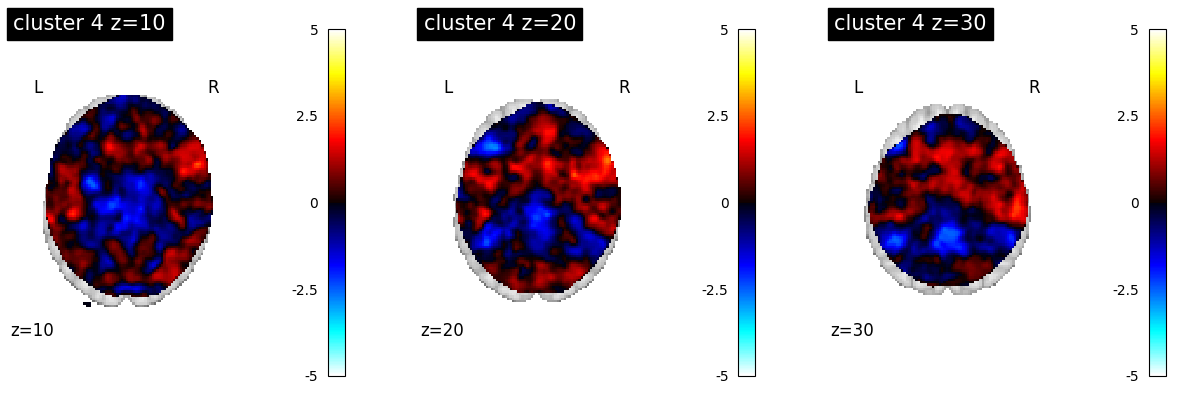

In [11]:
z_coords = [10, 20, 30]
img = nimg.load_img(os.path.join(basedir, 'mean_result.nii'))
label = 'mean results'
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, z_coord in enumerate(z_coords):
    plotting.plot_stat_map(img, cut_coords=[z_coord], display_mode='z', axes=axes[i], vmin=-5, vmax=5, title=f"{label} z={z_coord}")
plt.show()

# confs_ncc = dataset.loc[dataset["coregistration/cost_function/normalised_cross_correlation"] == True, 'id'].tolist()
# imgs = []
# for path in results:
#     for id in confs_ncc:
#         if id in path:
#             imgs.append(path)
# 
path = os.path.join(basedir, 'ncc_mean_result.nii')
# file_srv.write_mean_image(imgs, path)
img = nimg.load_img(path)
label = 'normalised cross correlation'
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, z_coord in enumerate(z_coords):
    plotting.plot_stat_map(img, cut_coords=[z_coord], display_mode='z', axes=axes[i], vmin=-5, vmax=5, title=f"{label} z={z_coord}")
plt.show()

id_by_cluster = dataset.groupby('cluster')['id'].apply(list).to_dict()
for cluster, configs in id_by_cluster.items():
    # imgs = []
    # for path in results:
    #     for config in configs:
    #         if config in path:
    #             imgs.append(path)
    path = os.path.join(basedir, f'cluster_{cluster}_mean_result.nii')
    # file_srv.write_mean_image(imgs, path)
    img = nimg.load_img(path)
    label = f'cluster {cluster}'
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for i, z_coord in enumerate(z_coords):
        plotting.plot_stat_map(img, cut_coords=[z_coord], display_mode='z', axes=axes[i], vmin=-5, vmax=5, title=f"{label} z={z_coord}")
    plt.show()

# Fit regressor decision tree model for all correlations metrics
- Try to predict the correlations for each configuration
- mean of correlations is computed independently for each train, test subset

In [16]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

results = []
feat_importances = []

for metric in target_vars:
    
    print(f"Fit model for [{metric}]")
    
    mean = (metric == 'mean_corr')
    
    X = dataset['id']
    y = dataset['id']

    test_size=0.3
    X_id_train, X_id_test, y_id_train, y_id_test = train_test_split(X, y, test_size=test_size)

    X_train = clusterize(X_id_train, 4, mean)
    X_train = X_train[0].drop(columns=ignored)
    
    X_test = clusterize(X_id_test, 4, mean)
    X_test = X_test[0] .drop(columns=ignored)
    
    y_train = clusterize(y_id_train, 4, mean)
    y_train = y_train[0][metric]
    
    y_test = clusterize(y_id_test, 4, mean)
    y_test = y_test[0][metric]
    
    # Train model
    regressor = tree.DecisionTreeRegressor(max_depth=4)
    regressor.fit(X_train, y_train)
    
    dot_data = tree.export_graphviz(regressor, out_file=None,
                                    feature_names=X_train.columns.values,
                                    filled=True, rounded=True,
                                    special_characters=True,
                                    leaves_parallel=True, proportion=True)
    graph = graphviz.Source(dot_data)  
    graph.render(f"{metric}")
    
    # learning curve
    # Define the range of training sizes
    train_sizes = np.linspace(0.1, 1.0, 10)
    
    # Compute the learning curve
    train_sizes, train_scores, test_scores = learning_curve(
        regressor, dataset.drop(columns=ignored), dataset[metric], train_sizes=train_sizes, cv=10, scoring='neg_mean_absolute_percentage_error'
    )
     
    features = dataset.drop(columns=ignored).columns
    importances = regressor.feature_importances_
    for i, feat in enumerate(features): 
        feat_importances.append((metric, feat, importances[i]))

    results.append((metric, 
                  mean_absolute_error(y_test, regressor.predict(X_test)),
                  mean_squared_error(y_test, regressor.predict(X_test)), 
                  mean_absolute_percentage_error(y_test, regressor.predict(X_test)),
                    np.mean(train_scores, axis=1),
                    np.std(train_scores, axis=1),
                    np.mean(test_scores, axis=1),
                    np.std(test_scores, axis=1)  
                    )
    )

# Fit classifier decision tree model for clusters
- Try to predict the cluster of each configuration
- Clustering is recomputed independently for test, train subsets

In [18]:
X = dataset['id']
y = dataset['id']
test_size=0.3
X_id_train, X_id_test, y_id_train, y_id_test = train_test_split(X, y, test_size=test_size)

X_train = clusterize(X_id_train, 4, False)
X_train = X_train[0].drop(columns=ignored)

X_test = clusterize(X_id_test, 4, False)
X_test = X_test[0] .drop(columns=ignored)

y_train = clusterize(y_id_train, 4, False)
y_train = y_train[0]['cluster']

y_test = clusterize(y_id_test, 4, False)
y_test = y_test[0]['cluster']

# Train the Decision Tree Classifier
classifier = tree.DecisionTreeClassifier(random_state=42)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
confu_matrix = confusion_matrix(y_test, y_pred)
print(confu_matrix)

dot_data = tree.export_graphviz(classifier, out_file=None, 
                         feature_names=X_train.columns.values,  
                         filled=True, rounded=True,
                         special_characters=True,
                                    leaves_parallel=True,proportion=True)
graph = graphviz.Source(dot_data)  
graph.render(f"cluster")

# learning curve
# Define the range of training sizes
train_sizes = np.linspace(0.1, 1.0, 10)

# Compute the learning curve
train_sizes, train_scores, test_scores = learning_curve(
    classifier, dataset.drop(columns=ignored), dataset['cluster'], train_sizes=train_sizes, cv=10, scoring='accuracy'
)
 
features = dataset.drop(columns=ignored).columns
importances = classifier.feature_importances_
for i, feat in enumerate(features): 
    feat_importances.append(('cluster', feat, importances[i]))

# accuracy ‘f1_samples’ precision score
# confusion matrix

results.append(('cluster', 
              mean_absolute_error(y_test, classifier.predict(X_test)),
              mean_squared_error(y_test, classifier.predict(X_test)), 
              mean_absolute_percentage_error(y_test, classifier.predict(X_test)),
                np.mean(train_scores, axis=1),
                np.std(train_scores, axis=1),
                np.mean(test_scores, axis=1),
                np.std(test_scores, axis=1)  
                )
)

[[  0 107   0   0]
 [ 60  52   0   0]
 [  0   0   0  38]
 [  0   0  20  23]]


In [19]:
results_df = pd.DataFrame(results, columns=['Metric', 'MAE',  'MSE', 'MAPE', 'train_mean', 'train_std', 'test_mean', 'test_std']).sort_values(by='MAPE', ascending=False)
results_df.head(14)

,Metric,MAE,MSE,MAPE,train_mean,train_std,test_mean,test_std
13,cluster,0.750000,0.750000,51.555556,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,from_e2981f97fc870a8fc8a66d9a40c3cc8dcb21be746...,0.046808,0.004486,10.647089,"[-0.06950652193879073, -0.0910203522044565, -0...","[0.0015494867480412506, 0.004042387218680227, ...","[-0.13014632162187806, -0.11475272775445786, -...","[0.0180651402389064, 0.010387247508380656, 0.0..."
3,from_1bd27c273e9f4d9eec9254015501cc8d1eeb109a6...,0.044421,0.004058,10.301913,"[-0.07066509401363173, -0.08948463985198467, -...","[0.0017719878450718045, 0.0046933280693573, 0....","[-0.1247505954589619, -0.11196428020101341, -0...","[0.010725296310745328, 0.009957235478631182, 0..."
7,from_2566dc31e9fbea6d892a21f56ecb62ff9df850705...,0.040473,0.004493,10.049100,"[-0.07741250622512823, -0.10041862583297649, -...","[0.004542181434398691, 0.002096342153197619, 0...","[-0.1268282040362571, -0.11178887925021315, -0...","[0.012456341084612077, 0.00845736087418685, 0...."
5,from_bdab21629030923da17e248d7689fc21eb1abea0d...,0.044601,0.004167,10.023858,"[-0.10102266119905759, -0.09791483214574487, -...","[0.006516506520965937, 0.0033843104261187195, ...","[-0.12855456335346, -0.11596837417010405, -0.1...","[0.0076700031956699515, 0.007741986352081251, ..."
11,from_05a74cdcbd5faa976b866eec5a083de5e3945cc85...,0.039743,0.003173,10.007511,"[-0.06496873642973937, -0.07566828034042697, -...","[0.00040557630002906506, 0.001117153285333612,...","[-0.11749239099157667, -0.09343200728420983, -...","[0.015282707438389605, 0.005944117824388297, 0..."
0,from_ref,0.044634,0.004358,9.917356,"[-0.10105488858879896, -0.09797580975765506, -...","[0.00649507931456542, 0.003342679003342889, 0....","[-0.12814571537789676, -0.11506223608282533, -...","[0.005019817568310234, 0.007651213318806997, 0..."
6,from_6363ceb4ad5221e2fd865e8ba9181032905c33814...,0.027585,0.001919,9.247538,"[-0.07119445232373779, -0.08533874109404369, -...","[0.0014896146992009506, 0.001838954135656165, ...","[-0.11195598448472947, -0.1023006999908449, -0...","[0.006913059679789611, 0.007194247825757195, 0..."
9,from_c475f858fc2881ef01d1d4b705346000d23d56508...,0.030896,0.001979,8.813091,"[-0.07658427834183727, -0.08202965276242355, -...","[0.004324050826146936, 0.0020624072519153896, ...","[-0.11985292579345079, -0.09653759940585523, -...","[0.01626934003991667, 0.00943548258097565, 0.0..."
2,from_33210c8a5f0e3921b5074eb7a4abd82a5b4f6e7ac...,0.033504,0.002323,8.543299,"[-0.061624132304521254, -0.07656283634064205, ...","[0.0007035524146642435, 0.0007243433825775234,...","[-0.11457364801315569, -0.0947343906053337, -0...","[0.011651861120769111, 0.004724486765600057, 0..."


In [20]:
importance_df = pd.DataFrame(feat_importances, columns=['Metric', 'Feature', 'Importance']).sort_values(by='Importance', ascending=False)
importance_df.head(100)

,Metric,Feature,Importance
141,from_1bd27c273e9f4d9eec9254015501cc8d1eeb109a6...,coregistration/cost_function/normalised_cross_...,0.757890
179,from_e2981f97fc870a8fc8a66d9a40c3cc8dcb21be746...,coregistration/cost_function/normalised_cross_...,0.749690
217,from_bdab21629030923da17e248d7689fc21eb1abea0d...,coregistration/cost_function/normalised_cross_...,0.748541
103,from_33210c8a5f0e3921b5074eb7a4abd82a5b4f6e7ac...,coregistration/cost_function/normalised_cross_...,0.732662
445,from_05a74cdcbd5faa976b866eec5a083de5e3945cc85...,coregistration/cost_function/normalised_cross_...,0.732363
...,...,...,...
390,from_5b935ba44056218711fe041d9e5000904a788b010...,motion_correction_realignment/register_to/mean,0.000000
391,from_5b935ba44056218711fe041d9e5000904a788b010...,spatial_normalization/algorithm/linear,0.000000
392,from_5b935ba44056218711fe041d9e5000904a788b010...,spatial_normalization/bias_regularisation/medium,0.000000
393,from_5b935ba44056218711fe041d9e5000904a788b010...,motion_correction_realignment/register_to/first,0.000000


# Mean absolute percentage error per metric

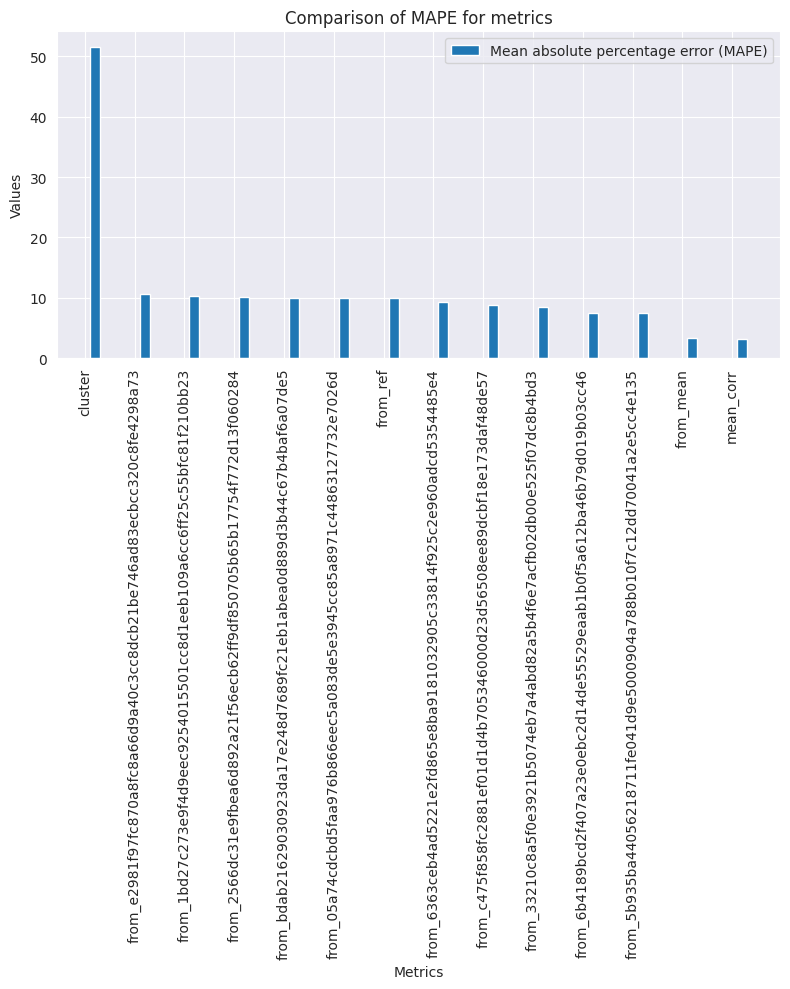

In [21]:
# Plotting
fig, ax = plt.subplots(figsize=(8, 10))
bar_width = 0.2
index = np.arange(len(results_df['Metric']))

# Plot bars for each metric
bar3 = ax.bar(index + 2 * bar_width, results_df['MAPE'], bar_width, label='Mean absolute percentage error (MAPE)')

# Adding labels and title
ax.set_xlabel('Metrics')
ax.set_ylabel('Values')
ax.set_title('Comparison of MAPE for metrics')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(results_df['Metric'])
ax.legend()

# Display the plot
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Learning curves of fitted models

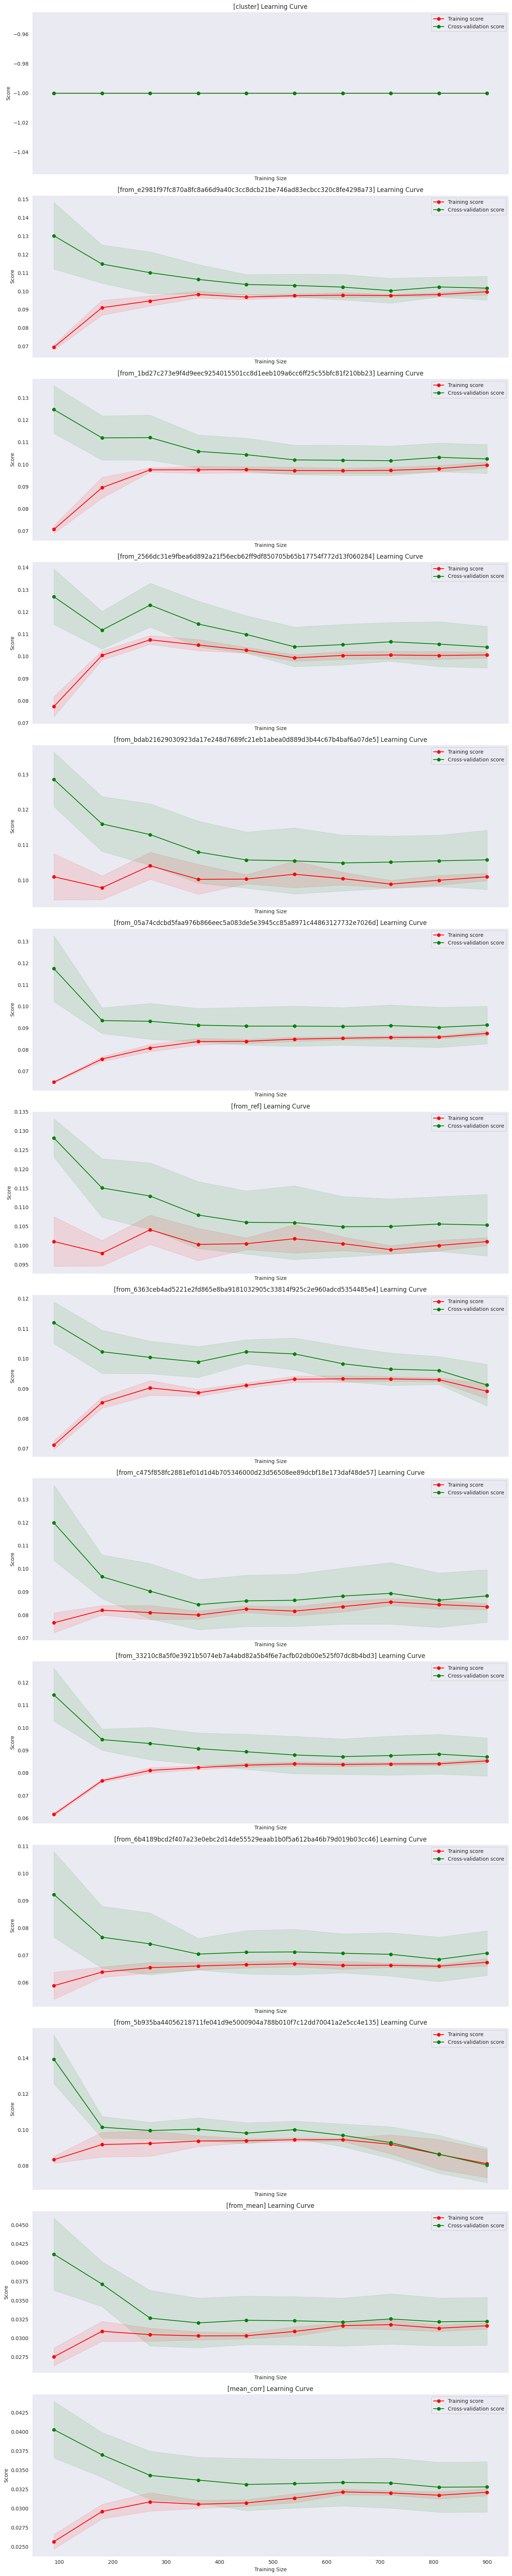

In [22]:
# Plotting
num_metrics = len(results_df)
fig, axes = plt.subplots(nrows=num_metrics, figsize=(num_metrics, num_metrics * 5), sharex=True)

for i, (index, row) in enumerate(results_df.iterrows()):
    ax = axes[i]
    ax.plot(train_sizes, -row['train_mean'], 'o-', color='r', label='Training score')
    ax.plot(train_sizes, -row['test_mean'], 'o-', color='g', label='Cross-validation score')
    ax.fill_between(train_sizes, -row['train_mean'] - row['train_std'], -row['train_mean'] + row['train_std'], alpha=0.1, color='r')
    ax.fill_between(train_sizes, -row['test_mean'] - row['test_std'], -row['test_mean'] + row['test_std'], alpha=0.1, color='g')
    ax.grid()
    ax.set_xlabel('Training Size')
    ax.set_ylabel('Score')
    ax.set_title(f'[{row["Metric"]}] Learning Curve')
    ax.legend(loc='best')

plt.tight_layout()
plt.show()

# Computational cost

In [23]:
with open('/home/ymerel/storage/results/auditory/jobs.json', 'r') as file:
        data = json.load(file)

In [30]:
jobs = []
run_hours = 0
post_hours = 0
times = []
for id, job in data['jobs'].items():
    if job['owner'] == 'ymerel' and job['state'] == 'Terminated':
        if job['command'] == '/home/ymerel/fmri-conf-runner/run_configs.sh':
            times.append((job['stop_time'] - job['start_time']) / 60)
            run_hours += (job['stop_time'] - job['start_time']) / 3600
        if job['command'] == '/home/ymerel/fmri-conf-runner/postprocess.sh':
            post_hours += (job['stop_time'] - job['start_time']) / 3600
        jobs.append(job)
print(f"[pipelines] Total runtime (h) : {run_hours}")
print(f"[pipelines] Runtime per pipelines (min) : {(run_hours / 1000)*60}")
print(f"[postprocessing] Total runtime (h) : {post_hours}")

[pipelines] Total runtime (h) : 49.05666666666668
[pipelines] Runtime per pipelines (min) : 2.943400000000001
[postprocessing] Total runtime (h) : 28.629166666666663
